In [94]:
import numpy as np
import scipy.stats as stats
import pandas as pd
# import datetime as dt

# Simulation of gene expressed to protein to dimer

# Description of problem

Gene transcription system:

$G\rightarrow_{25} G+M$ 

$M\rightarrow_{1000} M+P$

$P+P\rightarrow_{0.001}D$

$M\rightarrow_{0.1} \phi$ 

$P\rightarrow_1\phi$

$\lambda_1 = 25X_G$

$\lambda_2 = 1000X_M$

$\lambda_3 = 0.001X_P(X_P-1)$

$\lambda_4 = 0.1X_M$

$\lambda_5 = X_P$

#### Let $X_t=(X_M, X_P, X_D)_t$ be the state vector, the jumping vectors of 3 chemicals when each actions happens are: 
$[1, 0, 0], [0, 1, 0], [0, -2, 1], [-1, 0, 0], [0, -1, 0]$

#### The state equations of 3 chemicals are written below: (Note $X_G$ is always 1)

- $X_M(t) = X_M(0) + Y_1(\int_0^t 25X_G(s) ds)  - Y_4(0.1\int_0^t X_M(s) ds)$
- $X_P(t) = X_P(0) + Y_2(\int_0^t 1000X_M(s) ds) - 2Y_3(\int_0^t 0.001X_P(s)(X_P(s)-1) ds) - Y_5(\int_0^t X_P(s) ds)$
- $X_D(t) = X_D(0) + Y_3(\int_0^t 0.001X_P(s)(X_P(s)-1) ds)$

Definition of lambdas and reaction vectors

In [172]:
lambdaFuncs = lambda X_M, X_P, X_D : np.array([25, 
                                               1000 * X_M, 
                                               0.001 * X_P * (X_P - 1),
                                               0.1 * X_M,
                                               X_P])

vectors = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, -2, 1],
                    [-1, 0, 0],
                    [0, -1, 0]])

## 1. Stochastic Simulation Alglorithm (Exact simulation of chemical reaction model)

In [173]:
def stochasticSimulationAlgorithem(intial_State = np.array([0, 0, 0]), record_history = False): 
    '''If record history = True, returns history data frame,
       By default it's set False for saving memory, when simulating many paths to calculate mean.
    '''
    X = np.array(intial_State)
    T = 1
    t = 0
    
    reactions_history = []
    indexes  = []
    
    while t < T:
        lambdas     = lambdaFuncs(*X)
        lambdaTotal = np.sum(lambdas)
        U1, U2      = np.random.uniform(size = 2)
        t           = t - np.log(U1)/lambdaTotal
        lambdaSteps = np.cumsum(lambdas)/lambdaTotal
        if t < T:
            mask = [n for n, x in enumerate(lambdaSteps) if U2 <= x]
            if len(mask) == 0:
                continue
            else:
                reaction_index  = mask[0]
                reaction_vector = vectors[reaction_index]
                X = X + reaction_vector
                if record_history:
                    indexes.append((reaction_index + 1, t))
                    reactions_history.append(X)
    if record_history:          
        reactions_history = pd.DataFrame(reactions_history, columns = ['mRNA', 'Protein', 'Dimer'], 
                                         index = pd.MultiIndex.from_tuples(indexes, names = ('Reaction', 'Time')))
        return X, reactions_history
    else:
        return X, 

Test of 1 path : Slow, on average a single path takes 0.6s

In [438]:
%%time

test_SSA = stochasticSimulationAlgorithem(record_history = True)
test_SSA[1]

CPU times: user 874 ms, sys: 88.9 ms, total: 963 ms
Wall time: 882 ms


mRNA  Protein  Dimer
Reaction Time                          
1        0.005204     1        0      0
2        0.008014     1        1      0
         0.010191     1        2      0
         0.012814     1        3      0
         0.012874     1        4      0
...                 ...      ...    ...
         0.999800    26     3335   6212
         0.999808    26     3336   6212
3        0.999887    26     3334   6213
2        0.999920    26     3335   6213
         0.999971    26     3336   6213

[26697 rows x 3 columns]

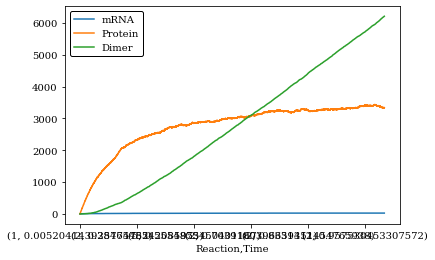

In [439]:
(test_SSA[1]).plot()

#### MC estimation: with only 1000 paths. (Taking 9 mins!!)

In [152]:
%%time
N_paths = 1000
Xs      = []

for i in range(N_paths):
    Xs.append(stochasticSimulationAlgorithem()[0][-1])
    
np.mean(Xs), np.var(Xs)

CPU times: user 9min 17s, sys: 8.36 s, total: 9min 25s
Wall time: 9min 22s


(3677.886, 1268627.9630040003)

In [160]:
np.std(Xs)

1126.3338594768427

## 2. Tau-leaping (Forward Euler Scheme)

#### (Let's just use numpy to generate poisson distribution first)

In [232]:
def tauLeaping(N_steps = 1000):
    T = 1
    h = T/N_steps
    X_tau = np.array([0, 0, 0])
    history = []
    for i in range(N_steps):
        lambdas  = lambdaFuncs(*X_tau)
        poissons = np.random.poisson(lambdas * h)
        X_tau    = X_tau + vectors.T.dot(poissons)
    return X_tau

#### MonteCarlo simulation

In [233]:
%%time
N_paths       = 1000
Xs_tauLeaping = []

for i in range(N_paths):
    Xs_tauLeaping.append(tauLeaping())

CPU times: user 25.1 s, sys: 106 ms, total: 25.2 s
Wall time: 25.3 s


In [238]:
Xs_tauLeaping = np.array(Xs_tauLeaping)
Xs_tauLeaping[:, 2].mean(), Xs_tauLeaping[:, 2].std()

(3717.945, 1049.9486501610447)

Comparison of SSA v.s. tau-leaping: to reach a same level of std, tau-leaping is much faster

## $3^*$. MLMC method

In [444]:
def computeOneLevelOneSample(level, M = 3):
    X_initial = np.array([0, 0, 0])
    Nf    = M**level
    T     = 1
    h     = T/Nf
    Xf    = X_initial
    Xc    = X_initial

    for n in range(Nf):
        lambdas_f = lambdaFuncs(*Xf)
        if n % M == 0:
            lambdas_c = lambdaFuncs(*Xc)
        lambdas_min = lambdas_f * (lambdas_f < lambdas_c) + lambdas_c * (lambdas_f >= lambdas_c)
        R1 = np.random.poisson(lambdas_min * h)
        R2 = np.random.poisson(np.abs(lambdas_f - lambdas_c) * h)
        Xf = Xf + vectors.T.dot(R1 + R2 * (lambdas_f > lambdas_c))
        Xc = Xc + vectors.T.dot(R1 + R2 * (lambdas_c > lambdas_f))
    return Xf[-1], Xc[-1], (Xf - Xc)[-1]

In [445]:
def simulateOneLevel(level, M = 3):
    # if level = l_0, we need the first output Xf_average, otherwise only diff is needed
    N_l = M**(level)
    Xf_sum  = 0
    Xc_sum  = 0
    diff_sum = 0
    for i in range(N_l):
        Xf, Xc, fine_coarse_diff = computeOneLevelOneSample(level, M)    
        Xf_sum += Xf
        Xc_sum += Xc
        diff_sum += fine_coarse_diff
    return Xf_sum/N_l, Xc_sum/N_l, diff_sum/N_l 

In [446]:
np.arange(5, 10, 1)

array([5, 6, 7, 8, 9])

In [447]:
def simulateMultiLevels_OneEstimator(starting_level = 2, max_level = 5, M = 3):
    X = simulateOneLevel(starting_level, M)[0]
    rangeOfLevels = np.arange(starting_level + 1, max_level + 1, 1)
    for level in rangeOfLevels:
        X = X + simulateOneLevel(level, M)[-1]
    return X

In [450]:
%%time
X_D_mlmc = simulateMultiLevels_OneEstimator(max_level = 5)

CPU times: user 3.42 s, sys: 6.32 ms, total: 3.43 s
Wall time: 3.43 s


In [451]:
X_D_mlmc

4001.086419753086

#### Variance of MLMC estimator: A significant decrease, even when N_estimators = 100

In [452]:
mlmc_estims = []

N_estimators = 100
for n in range(N_estimators):
    X_mlmc = simulateMultiLevels_OneEstimator(max_level = 5)
    mlmc_estims.append(X_mlmc)

np.mean(mlmc_estims), np.std(mlmc_estims)

(3674.7401234567897, 306.0355378935885)